# Training Deep Neural Networks

- Reading: Geron ch. 11

### Setup

Requires Python 3.7 or above:

In [1]:
import sys
assert sys.version_info >= (3, 7)

In [2]:
%pip install --q --user numpy --upgrade

Note: you may need to restart the kernel to use updated packages.


And TensorFlow ≥ 2.8:

In [4]:
from packaging import version
import tensorflow as tf
print(tf.__version__)
assert version.parse(tf.__version__) >= version.parse("2.8.0")

2.14.0


Define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Training a deep neural network is a complicated affair. Here are some
of the problems you could run into:

- Gradients growing ever smaller or larger,
when flowing backward through the DNN during training.

- You might not have enough training data for such a large network, or it might be
too costly to label.

- Training may be extremely slow.

- A model with millions of parameters would severely risk overfitting the training
set, especially if there are not enough training instances or if they are too noisy.

## The Vanishing/Exploding Gradients Problems

- The backpropagation algorithm's second phase works by going from the output layer to the input layer, propagating the error gradient along the way.

- Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a gradient descent step.

- **Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers.**

- As a result, the gradient descent update leaves the lower layers' connection weights virtually unchanged, and training never converges to a good solution. The *vanishing gradients problem*.

- In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is *the exploding gradients problem*.


- Xavier Glorot and Yoshua Bengio (2010) found a few suspects for the unstable gradients problem, including the combination of the popular sigmoid (logistic) activation function and the weight initialization technique that was most popular at
the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1).

- In short, the problem is due to the variance of the outputs of each layer becoming much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers.

- When inputs become large, the sigmoid function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when
backpropagation kicks in it has virtually no gradient to propagate back through the
network, and what little gradient exists keeps getting diluted as backpropagation
progresses down through the top layers, so there is really nothing left for the lower
layers.

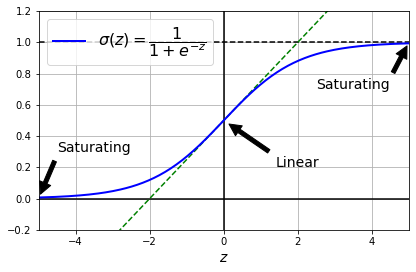

In [7]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

### Glorot and He Initialization

- Glorot and Bengio pointed out that we need the signal to flow properly in both
directions: in the forward direction when making predictions, and in the reverse
direction when backpropagating gradients.

- For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the
variance of its inputs, and we need the gradients to have equal variance before and
after flowing through a layer in the reverse direction.

- It is actually **not possible** to guarantee **both** unless the layer has an equal number of inputs (the **fan-in**) and outputs (the **fan-out**), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice:

- **Xavier/Glorot Initialization**: the connection weights of each layer must be initialized randomly with:

Normal distribution with mean 0 and variance
 $$\sigma^2=\frac{1}{fan_{AVG}}=\frac{2}{fan_{IN}+fan_{OUT}}$$ or,

 Uniform distribution between $-r$ and $+r=\sqrt{\frac{3}{fan_{AVG}}}$

 - Some papers have provided similar strategies for different activation functions:

 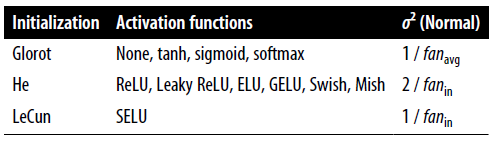

- By default, `Keras` uses Glorot initialization with a uniform distribution.

- You can switch to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"`.

In [9]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

- Any of the initializations listed in the table and more can be obtained using the `VarianceScaling` initializer.

- For example, if you want He initialization
with a uniform distribution and based on fanavg (rather than fanin), you can use the
following code:

In [10]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

### Nonsaturating Activation Functions

- The problems with unstable gradients were in part due to a poor choice of activation function.

- Activation functions other than the sigmoid behave much better in deep neural
networks.

  - In particular, the ReLU activation function, mostly because it does not
saturate for positive values, and also because it is very fast to compute.

- Unfortunately, the ReLU activation function suffers from a problem known as the **dying ReLUs**:
  - During training, some neurons effectively “die”, meaning they stop outputting anything other than 0.
  
  - A neuron dies when the input of the ReLU function is negative for all instances in the training set.
  
  - When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

- A variant of the ReLU function, such as
the leaky ReLU, often works better.

#### Leaky ReLU

- $\text{LeakyReLU}_\alpha(z)=\max(\alpha z, z)$
- The hyperparameter $\alpha < 1$ defines how much the function "leaks": it is the slope of the function for z < 0.

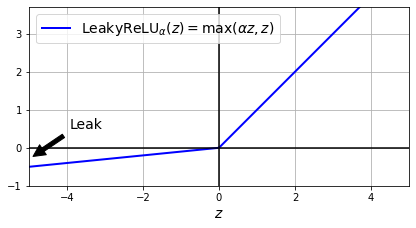

In [8]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1),
         "b-", linewidth=2,
         label=r"$\mathrm{LeakyReLU}_\alpha(z) = \max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-');
plt.plot([0, 0], [-1, 3.7], 'k-');
plt.grid(True);
props = dict(facecolor='black', shrink=0.1);
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3),
             arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$");
plt.axis([-5, 5, -1, 3.7]);
plt.gca().set_aspect("equal");
plt.legend();

save_fig("leaky_relu_plot");
plt.show();

- Having a slope for $z < 0$ ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up.

In [15]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

- In the *parametric leaky ReLU* (PReLU), $\alpha$ is a trainable parameter.

In [16]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.PReLU(),  # activation as a separate layer
    # [...]  # more layers
])

#### ELU

- ReLU, leaky ReLU, and PReLU all suffer from the fact that they are **not smooth functions**

-  Their derivatives abruptly change (at $z=0$).

- Now we will look at some **smooth variants of the ReLU activation function**.

- Clevert et al. (2015) proposed an activation function called the *exponential linear unit* (ELU), that outperformed all the ReLU variants in the authors' experiment.

$$\mathrm{ELU}_\alpha(z)=\cases{\alpha (\exp(z)-1) \quad \text{  if  } z < 0 \\
  z \qquad \qquad \qquad \text{  if  } z \geq 0} $$


Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [ ]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

#### SELU

- Klambauer et al. (2017) introduced the scaled ELU (SELU) activation function:

- A scaled variant of the ELU (about 1.05 times ELU, using α ≈ 1.67).

- If you build a neural network composed exclusively of a stack of dense layers
(i.e., an MLP), and if all hidden layers use the SELU activation function, then the
network will self-normalize: the output of each layer will tend to preserve a mean of 0
and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem.

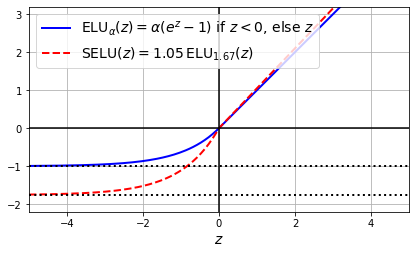

In [9]:
# Complement of the error function (~ 1 - normal cdf)
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [18]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**An example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [10]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [12]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [14]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [15]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 28s 13ms/step - loss: 1.8522 - accuracy: 0.2775 - val_loss: 1.4154 - val_accuracy: 0.4212
Epoch 2/5
1719/1719 [==============================] - 21s 12ms/step - loss: 1.1189 - accuracy: 0.5558 - val_loss: 0.9340 - val_accuracy: 0.6264
Epoch 3/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.9667 - accuracy: 0.6336 - val_loss: 1.1361 - val_accuracy: 0.5576
Epoch 4/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.9452 - accuracy: 0.6490 - val_loss: 0.9074 - val_accuracy: 0.6338
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.7754 - accuracy: 0.7141 - val_loss: 0.9138 - val_accuracy: 0.6670


The network managed to learn, despite how deep it is. 

#### GELU, Swish and Mish

- GELU was introduced in a 2016 paper by Dan Hendrycks and Kevin Gimpel.

- Another smooth variant of the ReLU activation function ($\Phi()$ is the normal cdf).

$$\mathrm{GELU}(z)= z\cdot \Phi(z)$$

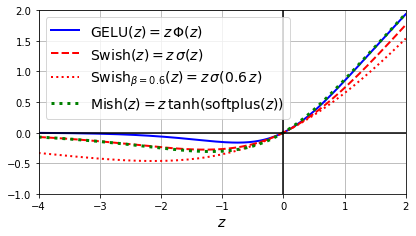

In [20]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

## Batch Normalization

- Although using He initialization along with ReLU can significantly reduce the danger of the vanishing/exploding gradients at the beginning of training, it doesn't guarantee that they won't come back during training!

- A technique called **batch normalization** (BN) addresses these problems.

- The technique consists of adding an operation in the model just before or after the activation function of each hidden layer.

- This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling,
the other for shifting.

- In other words, the operation lets the model learn the optimal scale and mean of each of the layer's inputs.

- In order to zero-center and normalize the inputs, the algorithm evaluates the mean and standard deviation of the input over the current mini-batch.

#### **Batch normalization algorithm**

1. $\boldsymbol{\mu}_B = \frac{1}{m_B}\sum_{i=1}^{m_B} \mathbf{x}^{(i)}$

2. $\boldsymbol{\sigma}_B^2 = \frac{1}{m_B}\sum_{i=1}^{m_B} \left(\mathbf{x}^{(i)}-\boldsymbol{\mu}_B\right)^2$

3. $\hat{\mathbf{x}}^{(i)} = \frac{\mathbf{x}^{(i)}-\boldsymbol{\mu}_B}{\sqrt{\boldsymbol{\sigma}_B+ɛ}}$

4. $\mathbf{z}^{(i)} = \boldsymbol{\gamma}⊗ \hat{\mathbf{x}}^{(i)} + \boldsymbol{\beta}$

- Most implementations of batch normalization estimate the final $\boldsymbol{\mu, \sigma}$ statistics during training by using a moving average of the layer's input means and standard deviations.

- To sum up, four parameter vectors are learned in each batch-normalized layer: $\boldsymbol{\gamma}$ (the output scale vector) and $\boldsymbol{\beta}$ (the output offset vector) are learned through regular backpropagation, and $\boldsymbol{\mu}$ (the final input mean vector) and $\boldsymbol{\sigma}$ (the final input standard deviation vector) are estimated using an exponential moving average.


- As with most things with Keras, implementing batch normalization is straightforward and intuitive. Just add a `BatchNormalization` layer before or after each hidden layer's activation function

In [21]:
# clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    # Add batch normalization
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    # Add batch normalization
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    # Add batch normalization
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [ ]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5559 - accuracy: 0.8094 - val_loss: 0.4016 - val_accuracy: 0.8558
Epoch 2/2
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4083 - accuracy: 0.8561 - val_loss: 0.3676 - val_accuracy: 0.8650


- Sometimes applying BN before the activation function works better (there's a debate on this topic).

- Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer has the offset parameter (so you can set `use_bias=False` when creating those layers):

In [24]:
# clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    # BN before activation
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

### Gradient Clipping

- Another technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold.

- This is called *gradient clipping*

- This technique is generally used in recurrent neural networks, where using batch normalization is tricky.

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

- It is generally not a good idea to train a very large DNN from scratch without first
trying to find an existing neural network that accomplishes a similar task to the one
you are trying to tackle.

- If you find such as neural network, then you can generally reuse most of its layers, except for the top ones.

- This technique is called **transfer learning**. It will not only speed up training considerably, but also requires significantly less training data.

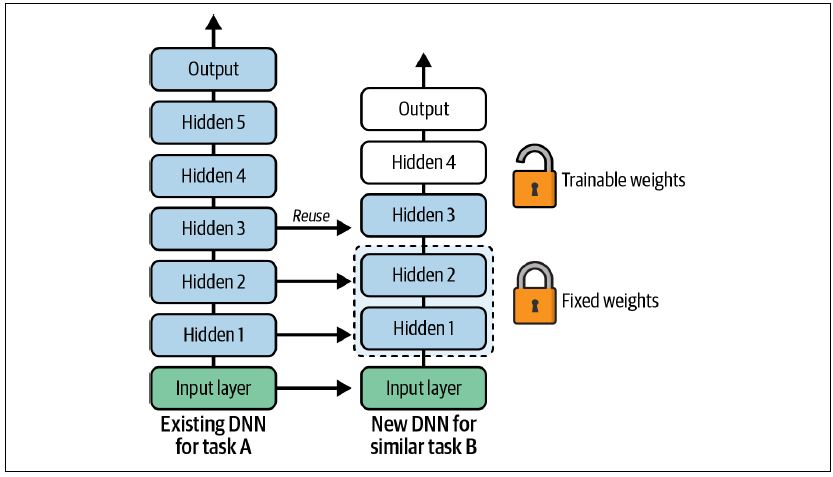

### An example

Suppose you have access to a DNN that was trained to classify pictures into 100
different categories, including animals, plants, vehicles, and everyday objects, and you now want to train a DNN to classify specific types of vehicles.

- These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network!

- The output layer of the original model should usually be replaced because it is most
likely not useful at all for the new task, and probably will not have the right number
of outputs.

- Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task.

- You want to find the right number of layers to reuse.

- Try freezing all the reused layers first (i.e., make their weights non-trainable so that gradient descent won’t modify them and they will remain fixed), then train your
model and see how it performs.

- Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves.

- The more training data you have, the more layers you can unfreeze.

#### Reusing a Keras model

- Suppose the Fashion MNIST dataset only contained eight classes — for example, all the classes except for sandal and shirt.

- Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let's call this **model A**.

- You now want to tackle a different task: you have images of T-shirts and pullovers, and you want to train a binary classifier: positive for T-shirts (and tops), negative for sandals.

- Your dataset is quite small; you only have
200 labeled images.

- When you train a new model for this task (let’s call it **model B**) with the same architecture as model A, you get 91.85% test accuracy.

- Let's split the fashion MNIST training set in two:

  * `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
  * `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

- The validation set and the test set are also split this way, but without restricting the number of images.

- We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers).



In [29]:
# split Fashion MNIST into tasks A and B, then train and save
# model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

# Reduce sample size
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 7s 5ms/step - loss: 1.1703 - accuracy: 0.6415 - val_loss: 0.7264 - val_accuracy: 0.7791
Epoch 2/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.6239 - accuracy: 0.7998 - val_loss: 0.5227 - val_accuracy: 0.8300
Epoch 3/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.4950 - accuracy: 0.8426 - val_loss: 0.4422 - val_accuracy: 0.8543
Epoch 4/20
1376/1376 [==============================] - 9s 7ms/step - loss: 0.4326 - accuracy: 0.8606 - val_loss: 0.3975 - val_accuracy: 0.8654
Epoch 5/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3950 - accuracy: 0.8702 - val_loss: 0.3699 - val_accuracy: 0.8752
Epoch 6/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.3694 - accuracy: 0.8777 - val_loss: 0.3507 - val_accuracy: 0.8792
Epoch 7/20
1376/1376 [==============================] - 6s 4ms/step - loss: 0.3509 - accuracy: 0.8823 - val_loss: 0.3352 - val_accuracy:

In [30]:
model_A.evaluate(X_test_A, y_test_A)

250/250 [==============================] - 1s 2ms/step - loss: 0.2930 - accuracy: 0.8994


[0.2929718494415283, 0.8993750214576721]

In [31]:
# train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 53ms/step - loss: 0.7106 - accuracy: 0.4500 - val_loss: 0.7019 - val_accuracy: 0.5114
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6901 - accuracy: 0.5100 - val_loss: 0.6830 - val_accuracy: 0.5875
Epoch 3/20
7/7 [==============================] - 0s 20ms/step - loss: 0.6701 - accuracy: 0.6150 - val_loss: 0.6657 - val_accuracy: 0.6538
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6487 - accuracy: 0.7300 - val_loss: 0.6490 - val_accuracy: 0.7052
Epoch 5/20
7/7 [==============================] - 0s 21ms/step - loss: 0.6308 - accuracy: 0.7700 - val_loss: 0.6316 - val_accuracy: 0.7458
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6118 - accuracy: 0.7950 - val_loss: 0.6147 - val_accuracy: 0.7923
Epoch 7/20
7/7 [==============================] - 0s 33ms/step - loss: 0.5931 - accuracy: 0.8300 - val_loss: 0.5982 - val_accuracy: 0.8408
Epoch 8/20
7/7 [===========

[0.4406895935535431, 0.9290000200271606]

Model B reaches 93% accuracy on the test set. Now let's try reusing the pretrained model A.

In [32]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [33]:
tf.random.set_seed(42)  #  ensure reproducibility

In [34]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [35]:
# creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [36]:
# IMPORTANT - We need to FREEZE the transfered layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [40]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=8,
                           validation_data=(X_valid_B, y_valid_B))

# Now unfreeze
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# IMPORTANT - You must recompile after unfreezing!
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=20,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/8
7/7 [==============================] - 0s 54ms/step - loss: 0.2985 - accuracy: 0.9650 - val_loss: 0.3338 - val_accuracy: 0.9238
Epoch 2/8
7/7 [==============================] - 0s 38ms/step - loss: 0.2896 - accuracy: 0.9700 - val_loss: 0.3212 - val_accuracy: 0.9288
Epoch 3/8
7/7 [==============================] - 0s 68ms/step - loss: 0.2781 - accuracy: 0.9700 - val_loss: 0.3091 - val_accuracy: 0.9228
Epoch 4/8
7/7 [==============================] - 0s 39ms/step - loss: 0.2671 - accuracy: 0.9700 - val_loss: 0.2998 - val_accuracy: 0.9288
Epoch 5/8
7/7 [==============================] - 0s 40ms/step - loss: 0.2589 - accuracy: 0.9700 - val_loss: 0.2917 - val_accuracy: 0.9347
Epoch 6/8
7/7 [==============================] - 0s 39ms/step - loss: 0.2521 - accuracy: 0.9700 - val_loss: 0.2850 - val_accuracy: 0.9298
Epoch 7/8
7/7 [==============================] - 0s 39ms/step - loss: 0.2435 - accuracy: 0.9700 - val_loss: 0.2821 - val_accuracy: 0.9397
Epoch 8/8
7/7 [===================

So, what's the final verdict?

In [41]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 5ms/step - loss: 0.2144 - accuracy: 0.9425


[0.21438319981098175, 0.9424999952316284]

More often than not, this works very well!

## Faster Optimizers

- Training a very large deep neural network can be painfully slow.

- A huge speed boost comes from using a faster optimizer than the regular gradient descent optimizer.


In [45]:
# a little function to test an optimizer on Fashion MNIST
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [25]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [26]:
%%time
history_sgd = build_and_train_model(optimizer)  # test with SGD

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7091 - accuracy: 0.7625 - val_loss: 0.4943 - val_accuracy: 0.8216
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4676 - accuracy: 0.8375 - val_loss: 0.4432 - val_accuracy: 0.8386
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4240 - accuracy: 0.8514 - val_loss: 0.4157 - val_accuracy: 0.8566
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3966 - accuracy: 0.8599 - val_loss: 0.3851 - val_accuracy: 0.8628
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3750 - accuracy: 0.8674 - val_loss: 0.3673 - val_accuracy: 0.8680
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3608 - accuracy: 0.8714 - val_loss: 0.3696 - val_accuracy: 0.8650
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3449 - accuracy: 0.8756 - val_loss: 0.3659 - val_accuracy:

## Momentum optimization

- Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance).

- This is the core idea behind momentum optimization (Boris Polyak, 1964).

- Regular gradient descent will take small steps when the slope is gentle and big steps when the slope is steep, but it will never pick up speed. As a result, regular gradient descent is generally much slower to reach the minimum than momentum optimization.


- Gradient descent updates the weights $\boldsymbol{\theta}$ by directly subtracting the gradient of the cost function with regard to the weights ($\nabla_\theta J(\boldsymbol{\theta})$) multiplied by the learning rate $\eta$:

$$\boldsymbol{\theta} ← \boldsymbol{\theta} - \eta \nabla_\theta J(\boldsymbol{\theta})$$

- The equation is does not care about what the earlier gradients were!

 - If the local gradient is tiny, it goes very slowly.


- Momentum optimization cares a great deal about what previous gradients were. At
each iteration, it subtracts the local gradient from the momentum vector $\mathbf{m}$, and it updates the weights by adding this momentum vector.

- In other words, the gradient is used as an acceleration, not a speed:

  1. $\mathbf m ← \beta \mathbf m - \eta \nabla_\theta J(\boldsymbol{\theta})$
  2. $\boldsymbol{\theta}← \boldsymbol{\theta} + \mathbf m$

- The hyperparameter $0<\beta< 1$ ("the momentum") simulates friction.

- If the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by $\frac{\eta}{1 - \beta}$.

- For example, if $\beta = 0.9$, then the terminal velocity is equal to 10 times the gradient times the learning rate, so
momentum optimization ends up going 10 times faster than gradient descent!

In [27]:
# Implementing momentum is so hard :)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [28]:
%%time
history_momentum = build_and_train_model(optimizer)  #

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6832 - accuracy: 0.7671 - val_loss: 0.5085 - val_accuracy: 0.8160
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4644 - accuracy: 0.8360 - val_loss: 0.4449 - val_accuracy: 0.8368
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4205 - accuracy: 0.8512 - val_loss: 0.4114 - val_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3941 - accuracy: 0.8606 - val_loss: 0.3855 - val_accuracy: 0.8594
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3725 - accuracy: 0.8675 - val_loss: 0.3744 - val_accuracy: 0.8650
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3585 - accuracy: 0.8725 - val_loss: 0.3659 - val_accuracy: 0.8672
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3419 - accuracy: 0.8767 - val_loss: 0.3774 - val_accuracy:

### Nesterov Accelerated Gradient

- One small variant to momentum ptimization, proposed by Yurii Nesterov in 1983 is almost always faster than regular momentum optimization.

- The Nesterov accelerated gradient (NAG) method, also known as Nesterov momentum optimization, measures the gradient of the cost function not at the local position $\boldsymbol \theta$ but slightly ahead in
the direction of the momentum, at $\boldsymbol \theta + \beta \mathbf m$.

  1. $\mathbf m ← \beta \mathbf m - \eta \nabla_\theta J(\boldsymbol{\theta}+\beta \mathbf m)$
  2. $\boldsymbol{\theta}← \boldsymbol{\theta} + \mathbf m$

In [29]:
# Super tough!
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001,
                                    momentum=0.9,
                                    nesterov=True)

In [30]:
%%time
history_nesterov = build_and_train_model(optimizer)  #

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6892 - accuracy: 0.7663 - val_loss: 0.4969 - val_accuracy: 0.8218
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4647 - accuracy: 0.8363 - val_loss: 0.4437 - val_accuracy: 0.8396
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4220 - accuracy: 0.8519 - val_loss: 0.4093 - val_accuracy: 0.8536
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3970 - accuracy: 0.8602 - val_loss: 0.3861 - val_accuracy: 0.8626
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3763 - accuracy: 0.8668 - val_loss: 0.3733 - val_accuracy: 0.8648
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3618 - accuracy: 0.8713 - val_loss: 0.3766 - val_accuracy: 0.8672
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3469 - accuracy: 0.8763 - val_loss: 0.3689 - val_accuracy:

## AdaGrad

- Gradient descent starts by quickly going down the steepest slope, which does not always point straight toward the global optimum. It would be nice if the algorithm could correct its direction earlier.

- The AdaGrad algorithm17 achieves this correction by **scaling down the gradient vector** along the steepest dimensions:

    1. $\mathbf s ← \mathbf s +  \nabla_\theta J(\boldsymbol{\theta}) \otimes  \nabla_\theta J(\boldsymbol{\theta})$
    2. $\boldsymbol{\theta} ← \boldsymbol{\theta} - \eta  \nabla_\theta J(\boldsymbol{\theta}) \oslash \sqrt{\mathbf s+\varepsilon}$



- The first step accumulatas the square of the gradients. The second step scales down the gradient descent step by a factor of $\sqrt{s}$

Adagrad decays the learning rate, and it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate! It helps point the resulting updates more directly toward the global optimum.

In [31]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [32]:
history_adagrad = build_and_train_model(optimizer)  # 

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0641 - accuracy: 0.6491 - val_loss: 0.7099 - val_accuracy: 0.7620
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6572 - accuracy: 0.7822 - val_loss: 0.5964 - val_accuracy: 0.8010
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5799 - accuracy: 0.8070 - val_loss: 0.5443 - val_accuracy: 0.8166
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5399 - accuracy: 0.8196 - val_loss: 0.5164 - val_accuracy: 0.8262
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5147 - accuracy: 0.8275 - val_loss: 0.4977 - val_accuracy: 0.8312
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4969 - accuracy: 0.8319 - val_loss: 0.4855 - val_accuracy: 0.8356
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4835 - accuracy: 0.8352 - val_loss: 0.4733 - val_accuracy:

### RMSProp

- AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum.

- The RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations, as opposed to all the gradients since the beginning of training:

    1. $\mathbf s ← \rho \mathbf s + (1-\rho) \nabla_\theta J(\boldsymbol{\theta}) \otimes  \nabla_\theta J(\boldsymbol{\theta})$
    2. $\boldsymbol{\theta} ← \boldsymbol{\theta} - \eta  \nabla_\theta J(\boldsymbol{\theta}) \oslash \sqrt{\mathbf s+\varepsilon}$


In [33]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [34]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5161 - accuracy: 0.8133 - val_loss: 0.4567 - val_accuracy: 0.8222
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3889 - accuracy: 0.8585 - val_loss: 0.4239 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3631 - accuracy: 0.8698 - val_loss: 0.4024 - val_accuracy: 0.8594
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3553 - accuracy: 0.8759 - val_loss: 0.3896 - val_accuracy: 0.8720
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3478 - accuracy: 0.8774 - val_loss: 0.3701 - val_accuracy: 0.8712
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3458 - accuracy: 0.8799 - val_loss: 0.4043 - val_accuracy: 0.8654
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3446 - accuracy: 0.8808 - val_loss: 0.4129 - val_accuracy:

### Adam Optimization

- **Adaptive moment estimation** (Adam) combines the ideas of momentum optimization and RMSProp: 

    - just like momentum optimization, it keeps track of an exponentially decaying average of past gradients;
    - and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients. 
    
    
- These are estimates of the mean (first moment) and (uncentered) variance of the gradients (second moment).

    1. $\mathbf m ← \beta_1 \mathbf m - (1-\beta_1) \nabla_\theta J(\boldsymbol{\theta})$
    
    2. $\mathbf s ← \beta_2 \mathbf s + (1-\beta_2) \nabla_\theta J(\boldsymbol{\theta}) \otimes  \nabla_\theta J(\boldsymbol{\theta})$
    
    3. $\hat{\mathbf m} ← \frac{\mathbf m}{1 - \beta_1^t}$
    
    4. $\hat{\mathbf s} ← \frac{\mathbf s}{1 - \beta_2^t}$
    
    5. $\boldsymbol{\theta} ← \boldsymbol{\theta} + \eta \hat{\mathbf m}  \oslash \sqrt{\hat{\mathbf s}+\varepsilon}$


In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                     beta_1=0.9,
                                     beta_2=0.999)

In [36]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5010 - accuracy: 0.8209 - val_loss: 0.4439 - val_accuracy: 0.8216
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3731 - accuracy: 0.8636 - val_loss: 0.3831 - val_accuracy: 0.8558
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3386 - accuracy: 0.8756 - val_loss: 0.3602 - val_accuracy: 0.8686
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3160 - accuracy: 0.8835 - val_loss: 0.3428 - val_accuracy: 0.8750
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2965 - accuracy: 0.8893 - val_loss: 0.3310 - val_accuracy: 0.8800
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2814 - accuracy: 0.8943 - val_loss: 0.3409 - val_accuracy: 0.8770
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2702 - accuracy: 0.8972 - val_loss: 0.3484 - val_accuracy:

**Adamax Optimization**

- Adam scales down the parameter updates by the ℓ2 norm of the time-decayed gradients.

- AdaMax replaces the ℓ2 norm with the ℓ∞ norm (a fancy way of saying the max).

- Specifically, it replaces step 2 with:

$$\mathbf s ← \max(\beta_2 \mathbf s, \vert \nabla_\theta J(\boldsymbol{\theta})\vert)$$

- AdaMax also drops step 4, and in step 5 it scales down the gradient updates by a factor of $\mathbf s$, which is the max of the absolute value of the time-decayed gradients.

In [37]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [38]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5420 - accuracy: 0.8116 - val_loss: 0.4396 - val_accuracy: 0.8364
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3981 - accuracy: 0.8593 - val_loss: 0.3913 - val_accuracy: 0.8528
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3601 - accuracy: 0.8697 - val_loss: 0.3595 - val_accuracy: 0.8708
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3345 - accuracy: 0.8782 - val_loss: 0.3468 - val_accuracy: 0.8746
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3145 - accuracy: 0.8863 - val_loss: 0.3235 - val_accuracy: 0.8800
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3012 - accuracy: 0.8903 - val_loss: 0.3358 - val_accuracy: 0.8792
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2865 - accuracy: 0.8946 - val_loss: 0.3374 - val_accuracy:

**Nadam Optimization**

- Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam.

In [39]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [40]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4840 - accuracy: 0.8275 - val_loss: 0.4309 - val_accuracy: 0.8374
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3669 - accuracy: 0.8665 - val_loss: 0.3828 - val_accuracy: 0.8534
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3337 - accuracy: 0.8769 - val_loss: 0.3645 - val_accuracy: 0.8696
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3127 - accuracy: 0.8859 - val_loss: 0.3299 - val_accuracy: 0.8784
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2935 - accuracy: 0.8916 - val_loss: 0.3308 - val_accuracy: 0.8764
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2792 - accuracy: 0.8964 - val_loss: 0.3562 - val_accuracy: 0.8788
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2672 - accuracy: 0.9004 - val_loss: 0.3338 - val_accuracy:

**AdamW Optimization**

- AdamW is a variant of Adam that integrates a regularization technique called *weight decay*.

- Weight decay reduces the size of the model’s weights at each training iteration by multiplying them by a decay factor such as 0.99.


In [41]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5,
                                      learning_rate=0.001,
                                      beta_1=0.9,
                                      beta_2=0.999)

In [42]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5009 - accuracy: 0.8203 - val_loss: 0.4087 - val_accuracy: 0.8446
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3764 - accuracy: 0.8625 - val_loss: 0.3740 - val_accuracy: 0.8562
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3405 - accuracy: 0.8738 - val_loss: 0.3418 - val_accuracy: 0.8744
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3155 - accuracy: 0.8842 - val_loss: 0.3493 - val_accuracy: 0.8750
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2978 - accuracy: 0.8892 - val_loss: 0.3452 - val_accuracy: 0.8730
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2847 - accuracy: 0.8941 - val_loss: 0.3482 - val_accuracy: 0.8786
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2726 - accuracy: 0.8977 - val_loss: 0.3312 - val_accuracy:

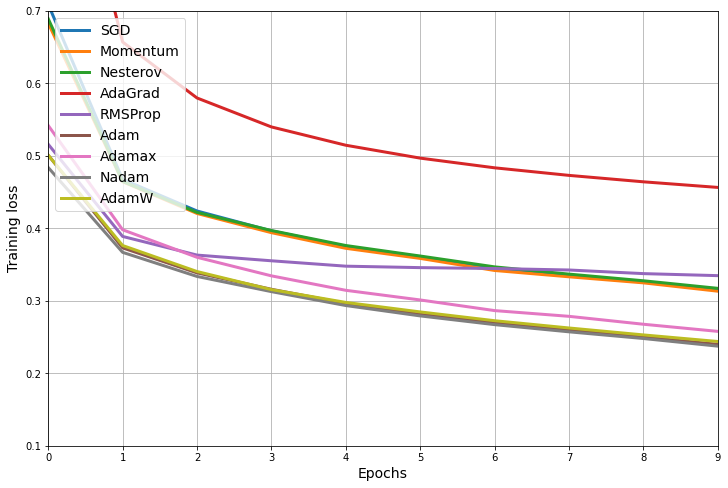

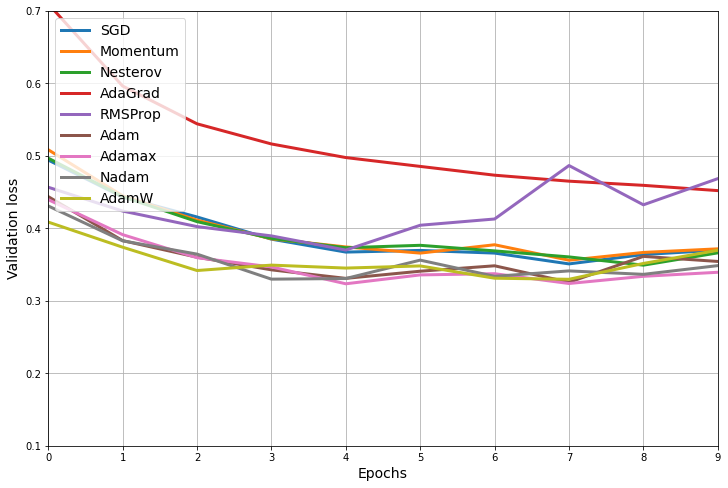

In [43]:
#visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

- Finding a good learning rate is very important. If you set it much too high, training may diverge. If you set it too low, training will eventually converge to the optimum, but it will take a very long time.

- You can find a good learning rate by training the model for a few hundred iterations, exponentially increasing the learning rate from a very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up. You can then reinitialize your model and train it with that learning rate.

- But you can do better than a constant learning rate: if you start with a large learning rate and then reduce it once training stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate.

- There are many different strategies to reduce the learning rate during training (*learning schedules*).

### Power Scheduling

- Let the learning rate drop hyperbolically: 

$$\eta(t)= \frac{\eta_0}{(1+t/s)^c}$$

In [46]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

- The `InverseTimeDecay` scheduler uses `learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)`. 

- If you set `staircase=True`, then it replaces `step / decay_step` with `floor(step / decay_step)`.

In [47]:
history_power_scheduling = build_and_train_model(optimizer)  # 

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7017 - accuracy: 0.7597 - val_loss: 0.4914 - val_accuracy: 0.8302
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4761 - accuracy: 0.8328 - val_loss: 0.4542 - val_accuracy: 0.8350
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4303 - accuracy: 0.8470 - val_loss: 0.4240 - val_accuracy: 0.8476
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4070 - accuracy: 0.8551 - val_loss: 0.3926 - val_accuracy: 0.8584
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3886 - accuracy: 0.8619 - val_loss: 0.3868 - val_accuracy: 0.8604
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3743 - accuracy: 0.8662 - val_loss: 0.3920 - val_accuracy: 0.8592
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3640 - accuracy: 0.8702 - val_loss: 0.3799 - val_accuracy:

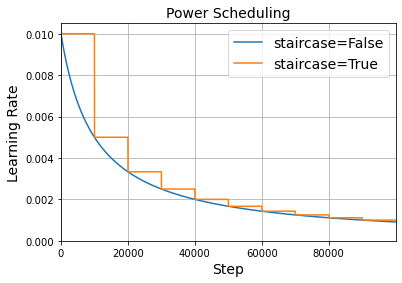

In [48]:
# plot power scheduling with staircase=True or False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps/decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Exponential Scheduling

- Set the learning rate to:

$$\eta(t)= \eta_0 (0.1)^{t/s}$$

```python
learning_rate = initial_learning_rate * decay_rate**(step/decay_steps)
```

In [49]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [50]:
history_exponential_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7154 - accuracy: 0.7530 - val_loss: 0.5045 - val_accuracy: 0.8178
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4797 - accuracy: 0.8325 - val_loss: 0.4610 - val_accuracy: 0.8316
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4314 - accuracy: 0.8480 - val_loss: 0.4190 - val_accuracy: 0.8474
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4078 - accuracy: 0.8565 - val_loss: 0.3998 - val_accuracy: 0.8532
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3902 - accuracy: 0.8627 - val_loss: 0.3901 - val_accuracy: 0.8554
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3778 - accuracy: 0.8660 - val_loss: 0.3916 - val_accuracy: 0.8614
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3690 - accuracy: 0.8693 - val_loss: 0.3813 - val_accuracy:

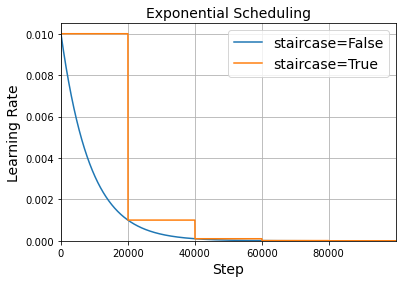

In [51]:
# plot exponential scheduling

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras provides a `LearningRateScheduler` callback class that lets you define your own scheduling function.

- Let's see how you could use it to implement exponential decay. Note that in this case the learning rate only changes at each epoch, not at each step:

In [53]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [54]:
# build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [55]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
                                            exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6872 - accuracy: 0.7641 - val_loss: 0.4816 - val_accuracy: 0.8312 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4634 - accuracy: 0.8365 - val_loss: 0.4519 - val_accuracy: 0.8352 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4165 - accuracy: 0.8522 - val_loss: 0.4172 - val_accuracy: 0.8536 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3927 - accuracy: 0.8599 - val_loss: 0.3830 - val_accuracy: 0.8610 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3739 - accuracy: 0.8655 - val_loss: 0.3762 - val_accuracy: 0.8628 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3593 - accuracy: 0.8719 - val_loss: 0.3811 - val_accuracy: 0.8664 - lr: 0.0056
Epoch 7/20
1719/1719 [==============================] - 4s

Alternatively, the schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to use a custom scheduling function that updates the learning rate at each iteration rather than at each epoch, you can write your own callback class like this:

In [59]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [60]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [61]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6736 - accuracy: 0.7681 - val_loss: 0.4940 - val_accuracy: 0.8262 - lr: 0.0089
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4709 - accuracy: 0.8338 - val_loss: 0.4560 - val_accuracy: 0.8346 - lr: 0.0079
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4263 - accuracy: 0.8483 - val_loss: 0.4226 - val_accuracy: 0.8478 - lr: 0.0071
Epoch 4/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4032 - accuracy: 0.8569 - val_loss: 0.3951 - val_accuracy: 0.8608 - lr: 0.0063
Epoch 5/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3843 - accuracy: 0.8640 - val_loss: 0.3873 - val_accuracy: 0.8616 - lr: 0.0056
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3701 - accuracy: 0.8682 - val_loss: 0.3893 - val_accuracy: 0.8624 - lr: 0.0050
Epoch 7/20
1719/1719 [==============================] - 4s

### Piecewise Constant Scheduling

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [ ]:
history_piecewise_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6942 - accuracy: 0.7617 - val_loss: 0.4892 - val_accuracy: 0.8318
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4751 - accuracy: 0.8340 - val_loss: 0.4603 - val_accuracy: 0.8346
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4280 - accuracy: 0.8500 - val_loss: 0.4245 - val_accuracy: 0.8542
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4035 - accuracy: 0.8581 - val_loss: 0.3867 - val_accuracy: 0.8626
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3828 - accuracy: 0.8650 - val_loss: 0.3827 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3665 - accuracy: 0.8700 - val_loss: 0.3880 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3539 - accuracy: 0.8730 - val_loss: 0.3669 - val_accuracy:

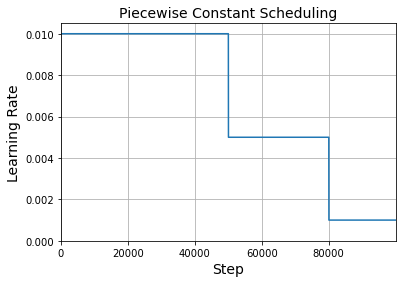

In [56]:
# plot piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually:

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
                        piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5433 - accuracy: 0.8087 - val_loss: 0.4586 - val_accuracy: 0.8288 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4487 - accuracy: 0.8439 - val_loss: 0.4608 - val_accuracy: 0.8350 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4263 - accuracy: 0.8502 - val_loss: 0.4234 - val_accuracy: 0.8568 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4241 - accuracy: 0.8537 - val_loss: 0.4359 - val_accuracy: 0.8490 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4080 - accuracy: 0.8584 - val_loss: 0.4165 - val_accuracy: 0.8560 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3544 - accuracy: 0.8738 - val_loss: 0.3830 - val_accuracy: 0.8662 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 3s

We've looked at `InverseTimeDecay`, `ExponentialDecay`, and `PiecewiseConstantDecay`. A few more schedulers are available in `tf.keras.optimizers.schedules`, here is the full list:

In [57]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A LearningRateSchedule that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay – A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay – A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay – A LearningRateSchedule that uses a polynomial decay schedule.


### Performance Scheduling

- Measure the validation error every $N$ steps (just like for early stopping), and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.

In [62]:
#  build and compile the model
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [63]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6753 - accuracy: 0.7671 - val_loss: 0.4812 - val_accuracy: 0.8306 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4691 - accuracy: 0.8340 - val_loss: 0.4560 - val_accuracy: 0.8344 - lr: 0.0100
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4222 - accuracy: 0.8487 - val_loss: 0.4209 - val_accuracy: 0.8526 - lr: 0.0100
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3984 - accuracy: 0.8579 - val_loss: 0.3843 - val_accuracy: 0.8648 - lr: 0.0100
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3772 - accuracy: 0.8657 - val_loss: 0.3863 - val_accuracy: 0.8616 - lr: 0.0100
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3610 - accuracy: 0.8707 - val_loss: 0.3802 - val_accuracy: 0.8670 - lr: 0.0100
Epoch 7/20
1719/1719 [==============================] - 3s

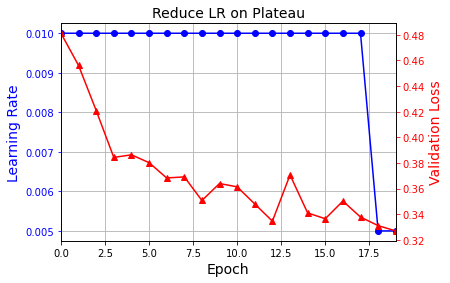

In [64]:
# plot performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle scheduling

- Contrary to the other approaches, 1cycle starts by increasing the initial learning rate $\eta_0$, growing linearly up to $\eta_1$ halfway through training.

- Then it decreases the learning rate linearly down to $\eta_0$ again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly).

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. 

    - increase the learning rate linearly during about half of training,
    - then reduce it linearly back to the initial learning rate,
    - and lastly reduce it down to close to zero linearly for the very last part of training.

In [ ]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2-lr1)*(self.iteration-iter1)/(iter2-iter1)+lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0,
                                   self.half_iteration,
                                   self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration,
                                   2 * self.half_iteration,
                                   self.max_lr,
                                   self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration,
                                   self.iterations,
                                   self.start_lr,
                                   self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

## Avoiding Overfitting Through Regularization

- Deep neural networks typically have tens of thousands of parameters, sometimes even millions. 
- This gives them an incredible amount of freedom and means they can fit a huge variety of complex datasets.
- But this great flexibility also makes the network prone to overfitting the training set. Regularization is often needed to prevent this.

## $\ell_1$ and $\ell_2$ regularization

- you can use $\ell_2$ regularization to constrain a neural network’s connection weights, and/or $\ell_1$ regularization if you want a sparse model (with many weights equal to 0).

In [65]:
layer = tf.keras.layers.Dense(100, activation="relu",
                kernel_initializer="he_normal",
                kernel_regularizer=tf.keras.regularizers.l2(0.01))

- The `l2()` function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss.

- Use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [66]:
tf.random.set_seed(42)  # for reproducibility

In [67]:
# IT IS A GOOD IDEA TO CREATE A CUSTOM HIDDEN LAYER AND STICK TO IT
from functools import partial

# This way we don't need to re-type the activation/init/regulariz parameters
RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    # Overwrite activation in output layer
    RegularizedDense(10, activation="softmax")
])

## Dropout

- A fairly simple algorithm for regularization:

    - At every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability $p$ of being temporarily “dropped out”, meaning it will be entirely ignored during this training step, but it may be active during the next step.
    
    - The hyperparameter `p` is called the dropout rate, and it is typically set between 10% and 50%.
    
    - After training, neurons don’t get dropped anymore.

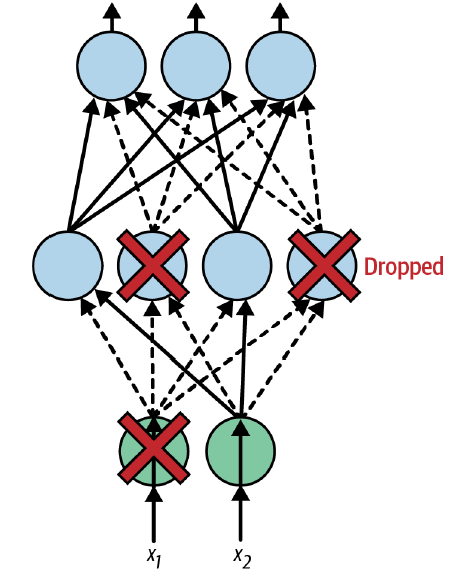

Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, you get a more robust network that generalizes better.

#### Important technical detail

- Suppose $p = 75\%$: on average only $25\%$ of all neurons are active at each step during training. 

- This means that after training, a neuron would be connected to four times as many input neurons as it would be during training.

- To compensate for this fact, we need to multiply each neuron’s input connection weights by four during training. If we don’t, the neural network will not perform well as it will see different data during and after training.

- More generally, we need to divide the connection weights by the keep probability $(1 – p)$ during training.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

- **NOTE**: Since dropout is only active during training, comparing the training loss and the validation loss can be misleading.

- In particular, a model may be overfitting the training set and yet have similar training and validation losses. So, make sure to evaluate the training loss without dropout (e.g., after training).

## MC Dropout

- A powerful technique, which can boost the performance of any trained dropout model without having to retrain it or even modify it at all.

- It also provides a much better measure of the model’s uncertainty, and it can be implemented in just a few lines of code.

In [ ]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

- Note that `model(X)` is similar to `model.predict(X)` except it returns a tensor rather than a NumPy array, and it supports the `training` argument.

- Setting `training=True` ensures that the `Dropout` layer remains active, so all predictions will be a bit different.

- We just make 100 predictions over the test set, and we compute their average.

    - Each call to the model returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape \[10000, 10\].
    
    - We stack 100 such matrices, so `y_probas` is a 3D array of shape \[100, 10000, 10\].
    
    - Once we average over the first dimension (`axis=0`) we get `y_proba`, an array of shape \[10000, 10\], like we would get with a single prediction.
    
    - Averaging over multiple predictions with dropout turned on gives us **a Monte Carlo estimate** that is generally more reliable than the result of a single prediction with dropout turned off.

`model.predict(X_test)`

- MC dropout tends to improve the reliability of the model’s probability estimates. This means that it’s less likely to be confident but wrong, which can be dangerous: just imagine a self-driving car confidently ignoring a stop sign. 

- It’s also useful to know exactly which other classes are most likely. 

- Additionally, you can take a look at **the standard deviation of the probability estimates**:

In [ ]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.001, 0.   , 0.096, 0.   , 0.162, 0.001,
       0.183], dtype=float32)

- If the model contains other layers that behave in a special way during training (such as `BatchNormalization` layers), then **you should not force training mode** like we just did.

- Instead, you should replace the Dropout layers with the following `MCDropout` class:

In [ ]:
class MCDropout(tf.keras.layers.Dropout):
    # subclass the Dropout layer
    # override the call() method to force training argument to True
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [ ]:
# how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
        for layer in model.layers
])
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
# the model works without retraining
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.17, 0.  , 0.76]],
      dtype=float32)

## Max norm

- A regularization technique that contrains the weights $\mathbf w$ of the incoming connection such that $\Vert\mathbf w\Vert_2\leq r$, where $r$ is the max-norm hyperparameter.

- Max-norm does **not** add a regularization loss term to the overall loss function.

- It is implemented by computing $\Vert\mathbf w \Vert_2$ after each training step and rescaling if needed: $\mathbf w \leftarrow \frac{\mathbf w}{\Vert\mathbf w \Vert_2}r$

In [ ]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [68]:
# how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Exercises

## 1. to 7.

1. Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.
2. No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.
3. It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17). The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.
5. If you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.
6. One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply ℓ<sub>1</sub> regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.
7. Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [ ]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [ ]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 17s 10ms/step - loss: 4.0462 - accuracy: 0.1597 - val_loss: 2.1441 - val_accuracy: 0.2036
Epoch 2/100
1407/1407 [==============================] - 12s 9ms/step - loss: 2.0667 - accuracy: 0.2320 - val_loss: 2.0134 - val_accuracy: 0.2472
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.9472 - accuracy: 0.2819 - val_loss: 1.9427 - val_accuracy: 0.2796
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8637 - accuracy: 0.3182 - val_loss: 1.8934 - val_accuracy: 0.3222
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7974 - accuracy: 0.3465 - val_loss: 1.8389 - val_accuracy: 0.3284
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.7446 - accuracy: 0.3664 - val_loss: 2.0006 - val_accuracy: 0.3030
Epoch 7/100
1407/1407 [==============================] - 12s 8ms/step - loss: 1.6974 - accuracy: 0.3852 - val_loss: 1.707

In [ ]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5062 - accuracy: 0.4676


[1.5061508417129517, 0.4675999879837036]

The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to `my_cifar10_bn_model`.

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 32s 18ms/step - loss: 2.0374 - accuracy: 0.2525 - val_loss: 1.8766 - val_accuracy: 0.3154
Epoch 2/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7874 - accuracy: 0.3542 - val_loss: 1.8784 - val_accuracy: 0.3268
Epoch 3/100
1407/1407 [==============================] - 20s 15ms/step - loss: 1.6806 - accuracy: 0.3969 - val_loss: 1.9764 - val_accuracy: 0.3252
Epoch 4/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6112 - accuracy: 0.4228 - val_loss: 1.7087 - val_accuracy: 0.3750
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5521 - accuracy: 0.4476 - val_loss: 1.6272 - val_accuracy: 0.4176
Epoch 6/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5030 - accuracy: 0.4660 - val_loss: 1.5401 - val_accuracy: 0.4452
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.4559 - accuracy: 0.4812 - val_loss: 1

[1.4236289262771606, 0.5073999762535095]

* *Is the model converging faster than before?* Much faster! The previous model took 29 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 12 epochs and continued to make progress until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 50.7% validation accuracy instead of 46.7%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 20s 13ms/step - loss: 1.9385 - accuracy: 0.3046 - val_loss: 1.8175 - val_accuracy: 0.3510
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7241 - accuracy: 0.3869 - val_loss: 1.7677 - val_accuracy: 0.3614
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6272 - accuracy: 0.4263 - val_loss: 1.6878 - val_accuracy: 0.4054
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5643 - accuracy: 0.4492 - val_loss: 1.6589 - val_accuracy: 0.4304
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5080 - accuracy: 0.4712 - val_loss: 1.5651 - val_accuracy: 0.4538
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4613 - accuracy: 0.4872 - val_loss: 1.5305 - val_accuracy: 0.4678
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4174 - accuracy: 0.5077 - val_loss: 1

[1.4607702493667603, 0.5026000142097473]

This model reached the first model's validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 50.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it's the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 18s 11ms/step - loss: 1.8950 - accuracy: 0.3239 - val_loss: 1.7556 - val_accuracy: 0.3812
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6618 - accuracy: 0.4130 - val_loss: 1.6563 - val_accuracy: 0.4114
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5770 - accuracy: 0.4432 - val_loss: 1.6507 - val_accuracy: 0.4232
Epoch 4/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.5081 - accuracy: 0.4672 - val_loss: 1.5892 - val_accuracy: 0.4566
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4561 - accuracy: 0.4902 - val_loss: 1.5382 - val_accuracy: 0.4696
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4094 - accuracy: 0.5050 - val_loss: 1.5236 - val_accuracy: 0.4818
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3636 - accuracy: 0.5232 - val_loss: 1

[1.4779616594314575, 0.498199999332428]

The model reaches 48.1% accuracy on the validation set. That's worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [ ]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [ ]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, tf.keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [ ]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

0.4984

We get back to roughly the accuracy of the model without dropout in this case (about 50.3% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 3s 8ms/step - loss: nan - accuracy: 0.1706


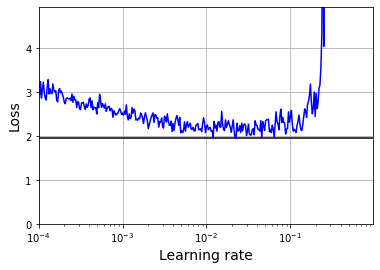

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 9ms/step - loss: 2.0559 - accuracy: 0.2839 - val_loss: 1.7917 - val_accuracy: 0.3768
Epoch 2/15
352/352 [==============================] - 3s 8ms/step - loss: 1.7596 - accuracy: 0.3797 - val_loss: 1.6566 - val_accuracy: 0.4258
Epoch 3/15
352/352 [==============================] - 3s 8ms/step - loss: 1.6199 - accuracy: 0.4247 - val_loss: 1.6395 - val_accuracy: 0.4260
Epoch 4/15
352/352 [==============================] - 3s 9ms/step - loss: 1.5451 - accuracy: 0.4524 - val_loss: 1.6202 - val_accuracy: 0.4408
Epoch 5/15
352/352 [==============================] - 3s 8ms/step - loss: 1.4952 - accuracy: 0.4691 - val_loss: 1.5981 - val_accuracy: 0.4488
Epoch 6/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4541 - accuracy: 0.4842 - val_loss: 1.5720 - val_accuracy: 0.4490
Epoch 7/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4171 - accuracy: 0.4967 - val_loss: 1.6035 - val_accuracy: 0.4470
Epoch 

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.7% to 52.0%).